# Exploring "Sequence to Sequence Learning with Neural Networks"

Machine translation had been for many years a very difficult task in machine learning.  While the tools of deep learning had proven to be essential in pushing the state-of-the-art in text classification, it took some time for them to prove their worth in machine translation.  The fundamental difference between text classification and machine translation is that in the former, the input to a model is a sequence and the output is a classification, while in the latter, the input is a sequence and the output is also a sequence.  In particular, in machine translation, the input sequence and output sequence are almost guaranteed to be of different lengths.  Researchers struggled to design an architecture that would allow for this difference.  The paper  ["Sequence to Sequence Learning with Neural Networks"](https://arxiv.org/pdf/1409.3215.pdf)
 was a major breakthrough, as the authors solve this problem with a kind of encoder-decoder architecture that is now called seq2seq.  The design of this architecture was discussed in detail in Part 1 of this report so please refer to that notebook for more details.  In addition, Part 1 provided exploratory analysis of the Multi30K dataset.  In this part of the report, I implement the seq2seq network and train it on the Multi30k dataset.  In particular, I will be testing the effects of the number of hidden dimensions and the number of layers in the encoder and decoder LSTMs.  I will also be looking at the effects of using pretrained word embeddings.

This part of the report will proceed as follows.  First, I will perform data preprocessing.  Then, the network will be constructed and trained.  Finally, I will evaluate the results and end with a few concluding remarks.





## Data Preprocessing

As discussed in Part 1, the dataset consists of 29000 training examples, 1014 validation examples, and 1000 test examples.  I will be using spacy to tokenize the dataset.  Then, I utilize the Field object in pytorch to construct the vocabularies.

I will also be downloading the word2vec pretrained English word embedding that has been trained on a large corpus of Google news articles.  Unfortunately, I was unable to find a suitable pretrained German word embedding, so it will have to suffice to work with only the English embedding.  Then, as the vocabulary of the Multi30k dataset is much smaller than the one corresponding to the word2vec embedding, to save memory, I will be grabbing from this embedding only the word vectors that are needed to train and test the network.

In [ ]:
#Importing libraries needed for entire notebook
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import spacy
import numpy as np
import random
import math
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from statistics import mean
from gensim.models.keyedvectors import KeyedVectors
import csv
from matplotlib import pyplot as plt
import pickle
import pandas as pd

In [ ]:
#downloading the english data

!python -m spacy download en_core_web_sm


     |████████████████████████████████| 12.0 MB 4.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
#Downloading the german data

!python -m spacy download de_core_news_sm

     |████████████████████████████████| 14.9 MB 5.3 MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-py3-none-any.whl size=14907055 sha256=1543ea20df40acbc24cd52741b4f383abe832b7ddf08d4ce47f428951ec7c653
  Stored in directory: /tmp/pip-ephem-wheel-cache-rpcf4xu8/wheels/00/66/69/cb6c921610087d2cab339062345098e30a5ceb665360e7b32a
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [ ]:
#Loading both datasets - Note that if you are using Google Colab, you may need
#to restart runtime before loading the data

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
#These functions define the tokenizers we will be using to preprocess the data

def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_de_reverse(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en_reverse(text):
    """
    Tokenizes English text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_en.tokenizer(text)][::-1]

In [ ]:
#These are the pytorch 'Field' objects we will use to construct the vocabularies

SRC = Field(tokenize = tokenize_en_reverse, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [ ]:
#Forming the datasets

train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.de'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


100%|██████████| 1.21M/1.21M [00:01<00:00, 764kB/s]


downloading validation.tar.gz


100%|██████████| 46.3k/46.3k [00:00<00:00, 248kB/s]


downloading mmt_task1_test2016.tar.gz


100%|██████████| 66.2k/66.2k [00:00<00:00, 237kB/s]


In [ ]:
#Building both vocabularies

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
#These dictionaries will help us create the word-to-vector embeddings

VOCAB = SRC.vocab.itos

word_to_idx = {w: i for i, w in enumerate(VOCAB)}
idx_to_word = {i: w for i, w in enumerate(VOCAB)}

In [ ]:
#Here, we retrieve the pretrained word2vec embedding

!brew install wget

!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

/bin/bash: brew: command not found
--2022-02-08 23:35:51--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.168.48
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.168.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  57.1MB/s    in 33s     

2022-02-08 23:36:24 (47.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
#Unzipping file

!gzip -d GoogleNews-vectors-negative300.bin.gz

In [ ]:
#This variable holds the downloaded word2vec representation
 
word_vectors = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [ ]:
#Here, we take only the vectors we need from the downloaded embedding

wv_matrix = []

for i in range(len(VOCAB)):
    word = idx_to_word[i]
    if word in word_vectors.vocab:
        #Getting vector for word in vocab if in embedding
        wv_matrix.append(word_vectors.word_vec(word))
    else:
        #If not in embedding, then we insert a random vector
        wv_matrix.append(np.random.uniform(-0.01, 0.01, 300).astype("float32"))

wv_matrix = np.array(wv_matrix)

In [ ]:
#Define the device to be used for training/testing

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Creating the data iterators

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = DEVICE)

## Building the Network

The network architecture was discussed in detail in Part 1.  You may note that I have added many more helper functions and methods in addition to what was presented in Part 1.  I have also modified how hyperparameters and other important variables are stored.  This will make repeated training of the network with different hyperparameters much easier.

Please note that I have determined it is best to translate from English to German rather than German to English.  This is because I only have a pretrained embedding for English, and early experimentation indicated that it may be prudent to locate the pretrained weights towards the beginning of the network.

I was assisted in the coding of the network by [this](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb) github repository:  

In [ ]:
#This is a general classifcation base class that will help with training/validation
#steps and store the losses and accuracies in a list of dictionaries

class ClassificationBase(nn.Module):   
    def training_step(self, source, target, pad_idx):
        """
        Computes training loss given a batch of x data
        and labels
        """
        out = self(source, target)
        out_dim = out.shape[-1]
        out = out[1:].view(-1, out_dim)
        target = target[1:].view(-1)
        loss = F.cross_entropy(out, target, ignore_index = pad_idx)
        return loss

    def accuracy(self, outputs, labels):
        """
        Computes accuracy of predictions given outputs of model and labels
        """
        x , preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item()/len(preds))

    def validation_step(self, source, target, pad_idx):
        """
        Given batch of x data and labels, computes the validation
        loss and accuracy - stores results in dictionary
        """
        out = self(source, target, teacher_forcing_ratio=0.0)   
        out_dim = out.shape[-1]
        out = out[1:].view(-1, out_dim)
        target = target[1:].view(-1)                 
        loss = F.cross_entropy(out, target, ignore_index = pad_idx)   
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, results):
        """
        Given list of dictionaries containing  validation 
        results of batches in epoch, returns mean results for
        epoch as dictionary
        """
        batch_losses = [x['val_loss'] for x in results]
        epoch_loss = torch.stack(batch_losses).mean()      
        return {'val_loss': epoch_loss.item()}#, 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        """
        Prints results of epoch given epoch number and epoch results dictionary
        """
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
          epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
#This class creates the encoder portion of the network

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, wv_matrix):
        super().__init__()
        
        self.hid_dim = hid_dim

        #This defines the number of LSTM layers
        self.n_layers = n_layers 

        self.embedding = nn.Embedding(input_dim, emb_dim)

        #This switch determines whether of not to use pretrained weights for embedding
        if wv_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(wv_matrix))
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):   
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

In [ ]:
#This class creates the decoder portion of the network

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim

        self.hid_dim = hid_dim

        #This defines the number of LSTM layers
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):       
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))       
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell

In [ ]:
#This class defines the network.  It includes a number of methods for training, testing, etc.

class Seq2Seq(ClassificationBase):
    def __init__(self, **kwargs):
        super().__init__()

        self.OPTIMIZER = kwargs['OPTIMIZER']

        #This variable helps normalize the gradients
        self.CLIP = kwargs['CLIP']
        self.EPOCHS = kwargs['EPOCHS']
        self.DEVICE = kwargs['DEVICE']
        self.INPUT_DIM = kwargs['INPUT_DIM']
        self.OUTPUT_DIM = kwargs['OUTPUT_DIM']
        self.ENC_EMB_DIM = kwargs['ENC_EMB_DIM']
        self.DEC_EMB_DIM = kwargs['DEC_EMB_DIM']
        self.HID_DIM = kwargs['HID_DIM']
        self.N_LAYERS = kwargs['N_LAYERS']
        self.ENC_DROPOUT = kwargs['ENC_DROPOUT']
        self.DEC_DROPOUT = kwargs['DEC_DROPOUT']
        self.SRC = kwargs['SRC']
        self.TRG = kwargs['TRG']
        self.wv_matrix = kwargs['WV_MATRIX']

        self.ENCODER = Encoder(self.INPUT_DIM, 
                               self.ENC_EMB_DIM, 
                               self.HID_DIM, 
                               self.N_LAYERS, 
                               self.ENC_DROPOUT,
                               self.wv_matrix)
        
        self.DECODER = Decoder(self.OUTPUT_DIM, 
                               self.DEC_EMB_DIM, 
                               self.HID_DIM, 
                               self.N_LAYERS, 
                               self.DEC_DROPOUT)
        
        self.results = None
        
        assert self.ENCODER.hid_dim == self.DECODER.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert self.ENCODER.n_layers == self.DECODER.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.DECODER.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.DEVICE)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.ENCODER(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.DECODER(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

    @torch.no_grad()
    def evaluate(self, val_iter):
        """
        Given validation iterator returns dictionary
        of validation loss, accuracy for epoch
        """
        self.eval()
        results = []
        for i, batch in enumerate(val_iter):
            source = batch.src
            target = batch.trg
            out = self.validation_step(source, target, self.TRG.vocab.stoi[TRG.pad_token])
            results.append(out)
        return self.validation_epoch_end(results)

    def retrieve_sent(self, sent_tens, voc):
        """
        Given a sentence in the form of a tensor, returns
        a list consisting of the words of the sentence.

        voc - either 'source' or 'target': indicates whether tensor is from
        source or target language
        """
        sent = []
        for j in range(sent_tens.size()[0]):
            if voc == 'source':
                idx = (-1)*j-1
                src_word = self.SRC.vocab.itos[sent_tens[idx].item()]
                if src_word not in ['<eos>', '<sos>', '<unk>', '<pad>'] and src_word not in '.,:;\'"/?()-!':
                    sent.append(src_word)
            if voc == 'target':
                trg_word = self.TRG.vocab.itos[sent_tens[j].item()]
                if trg_word not in ['<eos>', '<sos>', '<unk>', '<pad>'] and trg_word not in '.,:;\'"/?()-!':
                    sent.append(trg_word)
        return sent

    def bleu(self, data, smooth_method='1'):
        """
        Given a data iterator, returns the mean BLEU score for iterator.

        smooth_method = 1 -> Epsilon smoothing
        smooth_method = 2 -> +1 smoothing
        """
        bleu = 0
        scores = []
        for _, batch in enumerate(data):
            src = batch.src
            trg = batch.trg
            #push through model and get translation
            out = self(src,trg)
            pred = out.argmax(2)
            #Go through datapoint by datapoint
            for i in range(pred.size()[1]):
                trg_sent_tens = trg[:,i]
                pred_sent_tens = pred[:,i]
                #Turn target and translation tensors into actual sentences
                trg_sent = self.retrieve_sent(trg_sent_tens, 'target')
                pred_sent = self.retrieve_sent(pred_sent_tens, 'target')
                #Bleu Score Method 1 - Epsilon smoothing
                if smooth_method == '1':
                    score = sentence_bleu([trg_sent], pred_sent, smoothing_function=SmoothingFunction().method1)
                #Bleu score Method 2 - +1 Smoothing
                if smooth_method == '2':
                    score = sentence_bleu([trg_sent], pred_sent, smoothing_function=SmoothingFunction().method2)
                scores.append(score)
        return mean(scores), scores

    def fit(self, train_iter, val_iter):
        """
        Given training and validation iterator, returns list of dictionaries,
        one for each epoch, containing train and val loss and val accuracy (BLEU score)
        """
        history = []
        #Define optimizer and parameters to optimize:
        optimizer = self.OPTIMIZER(self.parameters())

        for name, param in self.named_parameters():
            nn.init.uniform_(param.data, -0.08, 0.08)
        for epoch in range(self.EPOCHS):
            # Training Phase 
            self.train()
            train_losses = []
            for i, batch in enumerate(train_iter):
                source = batch.src
                target = batch.trg
                loss = self.training_step(source, target, self.TRG.vocab.stoi[TRG.pad_token])
                train_losses.append(loss)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), self.CLIP)
                optimizer.step()
                optimizer.zero_grad()
            # Validation phase
            result = self.evaluate(val_iter)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            mean_bleu, _ = self.bleu(val_iter, smooth_method='2')
            result['val_acc'] = mean_bleu
            #Print results of epoch:
            self.epoch_end(epoch, result)
            history.append(result)
        self.results = history

    def test(self, test_iter, smooth_method='1'):
        """
        Given test iterator, returns BLEU score for iterator
        smooth_method = 1 -> Epsilon smoothing
        smooth_method = 2 -> +1 smoothing  
        """
        return self.bleu(test_iter, smooth_method)

    def save_results(self, file_name):
        """
        Saves train/val loss and val accuracy history as csv
        file_name = '<file_name>.csv'
        """
        keys = self.results[0].keys()
        with open(file_name, 'w', newline='')  as output_file:
            dict_writer = csv.DictWriter(output_file, keys)
            dict_writer.writeheader()
            dict_writer.writerows(self.results)

    def save_model(self, file_name):
        """
        Saves weight dict of model
        file_name = '<file_name>.pt'
        """
        torch.save(self.state_dict(), file_name)



## Training the Models

Initial experimentation revealed that almost all the networks were overfitting after 20 or so epochs, so I will be training each network for 25.  I will be looking at two values for the hidden dimensions, 256 and 512, and two values for the number of LSTM layers, 1 and 2.  For the four combinations of these values, I will be training one network with the pretrained embedding and one without, so there will be a total of 8 networks trained.  During training, I will be keeping track of the training and validation loss, and I will also be computing the mean BLEU score on the validation data.  This was only done with the +1 smoothing.  More details concerning the smoothing methods will be discussed below.

In [ ]:
#Here, we define the parameters to be used for each of the eight models


#MODEL 1: Hidden Dimensions = 512; Number of LSTM Layers = 1; No pretrained embedding weights
params1 = {'EPOCHS': 25,
          'CLIP': 1,
          'OPTIMIZER': optim.Adam,
          'DEVICE': DEVICE,
          'INPUT_DIM': len(SRC.vocab),
          'OUTPUT_DIM': len(TRG.vocab),
          'ENC_EMB_DIM': 256,
          'DEC_EMB_DIM': 256,
          'HID_DIM': 512,
          'N_LAYERS': 1,
          'ENC_DROPOUT': 0.0,
          'DEC_DROPOUT': 0.0,
          'SRC': SRC,
          'TRG': TRG,
          'WV_MATRIX': None}

#MODEL 2: Hidden Dimensions = 512; Number of LSTM Layers = 1; Pretrained embedding weights
params2 = {'EPOCHS': 25,
          'CLIP': 1,
          'OPTIMIZER': optim.Adam,
          'DEVICE': DEVICE,
          'INPUT_DIM': len(SRC.vocab),
          'OUTPUT_DIM': len(TRG.vocab),
          'ENC_EMB_DIM': 300,
          'DEC_EMB_DIM': 256,
          'HID_DIM': 512,
          'N_LAYERS': 1,
          'ENC_DROPOUT': 0.0,
          'DEC_DROPOUT': 0.0,
          'SRC': SRC,
          'TRG': TRG,
          'WV_MATRIX': wv_matrix}

#MODEL 3: Hidden Dimensions = 256; Number of LSTM Layers = 1; No pretrained embedding weights
params3 = {'EPOCHS': 25,
          'CLIP': 1,
          'OPTIMIZER': optim.Adam,
          'DEVICE': DEVICE,
          'INPUT_DIM': len(SRC.vocab),
          'OUTPUT_DIM': len(TRG.vocab),
          'ENC_EMB_DIM': 256,
          'DEC_EMB_DIM': 256,
          'HID_DIM': 256,
          'N_LAYERS': 1,
          'ENC_DROPOUT': 0.0,
          'DEC_DROPOUT': 0.0,
          'SRC': SRC,
          'TRG': TRG,
          'WV_MATRIX': None}

#MODEL 4: Hidden Dimensions = 256; Number of LSTM Layers = 1; Pretrained embedding weights
params4 = {'EPOCHS': 25,
          'CLIP': 1,
          'OPTIMIZER': optim.Adam,
          'DEVICE': DEVICE,
          'INPUT_DIM': len(SRC.vocab),
          'OUTPUT_DIM': len(TRG.vocab),
          'ENC_EMB_DIM': 300,
          'DEC_EMB_DIM': 256,
          'HID_DIM': 256,
          'N_LAYERS': 1,
          'ENC_DROPOUT': 0.0,
          'DEC_DROPOUT': 0.0,
          'SRC': SRC,
          'TRG': TRG,
          'WV_MATRIX': wv_matrix}

#MODEL 5: Hidden Dimensions = 512; Number of LSTM Layers = 2; No pretrained embedding weights
params5 = {'EPOCHS': 25,
          'CLIP': 1,
          'OPTIMIZER': optim.Adam,
          'DEVICE': DEVICE,
          'INPUT_DIM': len(SRC.vocab),
          'OUTPUT_DIM': len(TRG.vocab),
          'ENC_EMB_DIM': 256,
          'DEC_EMB_DIM': 256,
          'HID_DIM': 512,
          'N_LAYERS': 2,
          'ENC_DROPOUT': 0.5,
          'DEC_DROPOUT': 0.5,
          'SRC': SRC,
          'TRG': TRG,
          'WV_MATRIX': None}

#MODEL 6: Hidden Dimensions = 512; Number of LSTM Layers = 2; Pretrained embedding weights
params6 = {'EPOCHS': 25,
          'CLIP': 1,
          'OPTIMIZER': optim.Adam,
          'DEVICE': DEVICE,
          'INPUT_DIM': len(SRC.vocab),
          'OUTPUT_DIM': len(TRG.vocab),
          'ENC_EMB_DIM': 300,
          'DEC_EMB_DIM': 256,
          'HID_DIM': 512,
          'N_LAYERS': 2,
          'ENC_DROPOUT': 0.5,
          'DEC_DROPOUT': 0.5,
          'SRC': SRC,
          'TRG': TRG,
          'WV_MATRIX': wv_matrix}

#MODEL 7: Hidden Dimensions = 256; Number of LSTM Layers = 2; No pretrained embedding weights
params7 = {'EPOCHS': 25,
          'CLIP': 1,
          'OPTIMIZER': optim.Adam,
          'DEVICE': DEVICE,
          'INPUT_DIM': len(SRC.vocab),
          'OUTPUT_DIM': len(TRG.vocab),
          'ENC_EMB_DIM': 256,
          'DEC_EMB_DIM': 256,
          'HID_DIM': 256,
          'N_LAYERS': 2,
          'ENC_DROPOUT': 0.5,
          'DEC_DROPOUT': 0.5,
          'SRC': SRC,
          'TRG': TRG,
          'WV_MATRIX': None}

#MODEL 8: Hidden Dimensions = 256; Number of LSTM Layers = 2; Pretrained embedding weights
params8 = {'EPOCHS': 25,
          'CLIP': 1,
          'OPTIMIZER': optim.Adam,
          'DEVICE': DEVICE,
          'INPUT_DIM': len(SRC.vocab),
          'OUTPUT_DIM': len(TRG.vocab),
          'ENC_EMB_DIM': 300,
          'DEC_EMB_DIM': 256,
          'HID_DIM': 256,
          'N_LAYERS': 2,
          'ENC_DROPOUT': 0.5,
          'DEC_DROPOUT': 0.5,
          'SRC': SRC,
          'TRG': TRG,
          'WV_MATRIX': wv_matrix}

#Dict to hold all parameters
params = {'Model 1': params1,
          'Model 2': params2,
          'Model 3': params3,
          'Model 4': params4,
          'Model 5': params5,
          'Model 6': params6,
          'Model 7': params7,
          'Model 8': params8}


In [ ]:
#Load model 1

model = Seq2Seq(**params1).to(DEVICE)

In [ ]:
#Train model 1

model.fit(train_iterator, valid_iterator)

Epoch [0], train_loss: 5.0872, val_loss: 5.1307, val_acc: 0.1217
Epoch [1], train_loss: 4.4696, val_loss: 4.9314, val_acc: 0.1364
Epoch [2], train_loss: 4.1917, val_loss: 4.7757, val_acc: 0.1524
Epoch [3], train_loss: 3.9702, val_loss: 4.6541, val_acc: 0.1634
Epoch [4], train_loss: 3.7586, val_loss: 4.5327, val_acc: 0.1697
Epoch [5], train_loss: 3.6067, val_loss: 4.4059, val_acc: 0.1830
Epoch [6], train_loss: 3.4324, val_loss: 4.2997, val_acc: 0.2038
Epoch [7], train_loss: 3.2724, val_loss: 4.2119, val_acc: 0.2154
Epoch [8], train_loss: 3.1477, val_loss: 4.0703, val_acc: 0.2264
Epoch [9], train_loss: 3.0161, val_loss: 3.9772, val_acc: 0.2357
Epoch [10], train_loss: 2.8634, val_loss: 3.9199, val_acc: 0.2440
Epoch [11], train_loss: 2.7424, val_loss: 3.8666, val_acc: 0.2535
Epoch [12], train_loss: 2.5833, val_loss: 3.8087, val_acc: 0.2560
Epoch [13], train_loss: 2.4884, val_loss: 3.7825, val_acc: 0.2616
Epoch [14], train_loss: 2.3780, val_loss: 3.7781, val_acc: 0.2678
Epoch [15], train_lo

In [ ]:
#Save model 1 results

model.save_results('results1.csv')

In [ ]:
#Save model 1 weights

model.save_model('model1.pt')

In [ ]:
#Load model 2

model = Seq2Seq(**params2).to(DEVICE)

In [ ]:
#Train model 2

model.fit(train_iterator, valid_iterator)

Epoch [0], train_loss: 5.0926, val_loss: 5.0757, val_acc: 0.1253
Epoch [1], train_loss: 4.4760, val_loss: 4.8927, val_acc: 0.1348
Epoch [2], train_loss: 4.1558, val_loss: 4.7551, val_acc: 0.1493
Epoch [3], train_loss: 3.9173, val_loss: 4.6013, val_acc: 0.1702
Epoch [4], train_loss: 3.7189, val_loss: 4.4258, val_acc: 0.1788
Epoch [5], train_loss: 3.5662, val_loss: 4.3264, val_acc: 0.1847
Epoch [6], train_loss: 3.3622, val_loss: 4.3417, val_acc: 0.2013
Epoch [7], train_loss: 3.2465, val_loss: 4.1847, val_acc: 0.2066
Epoch [8], train_loss: 3.1401, val_loss: 4.1041, val_acc: 0.2182
Epoch [9], train_loss: 3.0124, val_loss: 4.0998, val_acc: 0.2210
Epoch [10], train_loss: 2.8411, val_loss: 4.0303, val_acc: 0.2317
Epoch [11], train_loss: 2.7410, val_loss: 3.9773, val_acc: 0.2399
Epoch [12], train_loss: 2.6103, val_loss: 3.9397, val_acc: 0.2470
Epoch [13], train_loss: 2.4904, val_loss: 3.9053, val_acc: 0.2546
Epoch [14], train_loss: 2.3800, val_loss: 3.9035, val_acc: 0.2562
Epoch [15], train_lo

In [ ]:
#Save model 2 results

model.save_results('results2.csv')

In [ ]:
#Save model 2 weights

model.save_model('model2.pt')

In [ ]:
#Load model 3

model = Seq2Seq(**params3).to(DEVICE)

In [ ]:
#Train model 3

model.fit(train_iterator, valid_iterator)

Epoch [0], train_loss: 5.2827, val_loss: 5.1236, val_acc: 0.1229
Epoch [1], train_loss: 4.5742, val_loss: 4.9373, val_acc: 0.1307
Epoch [2], train_loss: 4.3151, val_loss: 4.8580, val_acc: 0.1374
Epoch [3], train_loss: 4.1039, val_loss: 4.7351, val_acc: 0.1512
Epoch [4], train_loss: 3.9365, val_loss: 4.6142, val_acc: 0.1626
Epoch [5], train_loss: 3.7961, val_loss: 4.4807, val_acc: 0.1704
Epoch [6], train_loss: 3.6385, val_loss: 4.3874, val_acc: 0.1837
Epoch [7], train_loss: 3.5196, val_loss: 4.3257, val_acc: 0.1959
Epoch [8], train_loss: 3.3908, val_loss: 4.1960, val_acc: 0.2085
Epoch [9], train_loss: 3.2961, val_loss: 4.1441, val_acc: 0.2149
Epoch [10], train_loss: 3.2046, val_loss: 4.0507, val_acc: 0.2219
Epoch [11], train_loss: 3.0739, val_loss: 4.0415, val_acc: 0.2289
Epoch [12], train_loss: 2.9893, val_loss: 3.9859, val_acc: 0.2336
Epoch [13], train_loss: 2.9215, val_loss: 3.8906, val_acc: 0.2408
Epoch [14], train_loss: 2.8311, val_loss: 3.8751, val_acc: 0.2434
Epoch [15], train_lo

In [ ]:
#Save model 3 results

model.save_results('results3.csv')

In [ ]:
#Train model 3 weights

model.save_model('model3.pt')

In [ ]:
#Load model 4

model = Seq2Seq(**params4).to(DEVICE)

In [ ]:
#Train model 4

model.fit(train_iterator, valid_iterator)

Epoch [0], train_loss: 5.2613, val_loss: 5.0876, val_acc: 0.1202
Epoch [1], train_loss: 4.5814, val_loss: 4.9575, val_acc: 0.1337
Epoch [2], train_loss: 4.3244, val_loss: 4.8278, val_acc: 0.1487
Epoch [3], train_loss: 4.0981, val_loss: 4.6716, val_acc: 0.1531
Epoch [4], train_loss: 3.8914, val_loss: 4.6077, val_acc: 0.1619
Epoch [5], train_loss: 3.7744, val_loss: 4.4197, val_acc: 0.1757
Epoch [6], train_loss: 3.6104, val_loss: 4.3456, val_acc: 0.1880
Epoch [7], train_loss: 3.4811, val_loss: 4.2482, val_acc: 0.2039
Epoch [8], train_loss: 3.3846, val_loss: 4.1814, val_acc: 0.2126
Epoch [9], train_loss: 3.2513, val_loss: 4.1194, val_acc: 0.2169
Epoch [10], train_loss: 3.1785, val_loss: 4.0103, val_acc: 0.2222
Epoch [11], train_loss: 3.0750, val_loss: 3.9926, val_acc: 0.2271
Epoch [12], train_loss: 2.9862, val_loss: 3.9373, val_acc: 0.2296
Epoch [13], train_loss: 2.8914, val_loss: 3.9297, val_acc: 0.2391
Epoch [14], train_loss: 2.8102, val_loss: 3.8810, val_acc: 0.2446
Epoch [15], train_lo

In [ ]:
#Save model 4 results

model.save_results('results4.csv')

In [ ]:
#Save model 4 weights

model.save_model('model4.pt')

In [ ]:
#Load model 5

model = Seq2Seq(**params5).to(DEVICE)

In [ ]:
#Train model 5

model.fit(train_iterator, valid_iterator)

Epoch [0], train_loss: 5.1779, val_loss: 5.1059, val_acc: 0.1104
Epoch [1], train_loss: 4.6310, val_loss: 4.8507, val_acc: 0.1350
Epoch [2], train_loss: 4.2685, val_loss: 4.7178, val_acc: 0.1542
Epoch [3], train_loss: 4.0929, val_loss: 4.5737, val_acc: 0.1587
Epoch [4], train_loss: 3.8927, val_loss: 4.5111, val_acc: 0.1664
Epoch [5], train_loss: 3.7414, val_loss: 4.3211, val_acc: 0.1829
Epoch [6], train_loss: 3.6013, val_loss: 4.2526, val_acc: 0.1929
Epoch [7], train_loss: 3.4638, val_loss: 4.1646, val_acc: 0.2027
Epoch [8], train_loss: 3.3194, val_loss: 4.0919, val_acc: 0.2149
Epoch [9], train_loss: 3.2096, val_loss: 4.0006, val_acc: 0.2188
Epoch [10], train_loss: 3.1139, val_loss: 3.9007, val_acc: 0.2339
Epoch [11], train_loss: 3.0000, val_loss: 3.8501, val_acc: 0.2394
Epoch [12], train_loss: 2.8991, val_loss: 3.8533, val_acc: 0.2505
Epoch [13], train_loss: 2.7978, val_loss: 3.7664, val_acc: 0.2536
Epoch [14], train_loss: 2.6870, val_loss: 3.7785, val_acc: 0.2632
Epoch [15], train_lo

In [ ]:
#Save model 5 results

model.save_results('results5.csv')

In [ ]:
#Save model 5 weights

model.save_model('model5.pt')

In [ ]:
#Load model 6

model = Seq2Seq(**params6).to(DEVICE)

In [ ]:
#Train model 6

model.fit(train_iterator, valid_iterator)

Epoch [0], train_loss: 5.1771, val_loss: 5.0889, val_acc: 0.1060
Epoch [1], train_loss: 4.5739, val_loss: 4.8233, val_acc: 0.1389
Epoch [2], train_loss: 4.2111, val_loss: 4.6240, val_acc: 0.1603
Epoch [3], train_loss: 3.9953, val_loss: 4.4463, val_acc: 0.1691
Epoch [4], train_loss: 3.7905, val_loss: 4.3198, val_acc: 0.1796
Epoch [5], train_loss: 3.6687, val_loss: 4.1533, val_acc: 0.1948
Epoch [6], train_loss: 3.4862, val_loss: 4.0587, val_acc: 0.2046
Epoch [7], train_loss: 3.3364, val_loss: 4.0110, val_acc: 0.2208
Epoch [8], train_loss: 3.1516, val_loss: 3.9260, val_acc: 0.2301
Epoch [9], train_loss: 3.0465, val_loss: 3.8231, val_acc: 0.2387
Epoch [10], train_loss: 2.9200, val_loss: 3.7750, val_acc: 0.2513
Epoch [11], train_loss: 2.8010, val_loss: 3.7427, val_acc: 0.2574
Epoch [12], train_loss: 2.6868, val_loss: 3.6415, val_acc: 0.2656
Epoch [13], train_loss: 2.6001, val_loss: 3.6104, val_acc: 0.2695
Epoch [14], train_loss: 2.4983, val_loss: 3.6542, val_acc: 0.2749
Epoch [15], train_lo

In [ ]:
#Save model 6 results

model.save_results('results6.csv')

In [ ]:
#Save model 6 weights

model.save_model('model6.pt')

In [ ]:
#Load model 7

model = Seq2Seq(**params7).to(DEVICE)

In [ ]:
#Train model 7

model.fit(train_iterator, valid_iterator)

Epoch [0], train_loss: 5.3616, val_loss: 4.9456, val_acc: 0.1158
Epoch [1], train_loss: 4.8275, val_loss: 4.9990, val_acc: 0.1220
Epoch [2], train_loss: 4.4778, val_loss: 4.7969, val_acc: 0.1437
Epoch [3], train_loss: 4.2899, val_loss: 4.7122, val_acc: 0.1507
Epoch [4], train_loss: 4.1116, val_loss: 4.6336, val_acc: 0.1561
Epoch [5], train_loss: 3.9961, val_loss: 4.4560, val_acc: 0.1659
Epoch [6], train_loss: 3.8592, val_loss: 4.3939, val_acc: 0.1723
Epoch [7], train_loss: 3.7405, val_loss: 4.2983, val_acc: 0.1829
Epoch [8], train_loss: 3.6352, val_loss: 4.2069, val_acc: 0.1922
Epoch [9], train_loss: 3.5156, val_loss: 4.1292, val_acc: 0.2034
Epoch [10], train_loss: 3.4268, val_loss: 4.0346, val_acc: 0.2143
Epoch [11], train_loss: 3.3447, val_loss: 3.9922, val_acc: 0.2204
Epoch [12], train_loss: 3.2507, val_loss: 3.9090, val_acc: 0.2243
Epoch [13], train_loss: 3.1704, val_loss: 3.8762, val_acc: 0.2317
Epoch [14], train_loss: 3.0808, val_loss: 3.8283, val_acc: 0.2335
Epoch [15], train_lo

In [ ]:
#Save model 7 results

model.save_results('results7.csv')

In [ ]:
#Save model 7 weights

model.save_model('model7.pt')

In [ ]:
#Load model 8

model = Seq2Seq(**params8).to(DEVICE)

In [ ]:
#Train model 8

model.fit(train_iterator, valid_iterator)

Epoch [0], train_loss: 5.3612, val_loss: 5.0069, val_acc: 0.1112
Epoch [1], train_loss: 4.8500, val_loss: 4.9496, val_acc: 0.1267
Epoch [2], train_loss: 4.4731, val_loss: 4.7709, val_acc: 0.1359
Epoch [3], train_loss: 4.2484, val_loss: 4.6395, val_acc: 0.1527
Epoch [4], train_loss: 4.0579, val_loss: 4.4481, val_acc: 0.1665
Epoch [5], train_loss: 3.8849, val_loss: 4.3310, val_acc: 0.1778
Epoch [6], train_loss: 3.7396, val_loss: 4.2394, val_acc: 0.1893
Epoch [7], train_loss: 3.6106, val_loss: 4.1459, val_acc: 0.1992
Epoch [8], train_loss: 3.4889, val_loss: 4.0496, val_acc: 0.2109
Epoch [9], train_loss: 3.3709, val_loss: 3.9866, val_acc: 0.2206
Epoch [10], train_loss: 3.2873, val_loss: 3.9031, val_acc: 0.2236
Epoch [11], train_loss: 3.1906, val_loss: 3.9174, val_acc: 0.2341
Epoch [12], train_loss: 3.1332, val_loss: 3.8397, val_acc: 0.2367
Epoch [13], train_loss: 3.0507, val_loss: 3.7872, val_acc: 0.2438
Epoch [14], train_loss: 2.9771, val_loss: 3.7435, val_acc: 0.2530
Epoch [15], train_lo

In [ ]:
#Save model 8 results

model.save_results('results8.csv')

In [ ]:
#Save model 8 weights

model.save_model('model8.pt')

## The Results

In [ ]:
#Lodaing training/validation results

df1 = pd.read_csv("/content/results1.csv")
df2 = pd.read_csv("/content/results2.csv")
df3 = pd.read_csv("/content/results3.csv")
df4 = pd.read_csv("/content/results4.csv")
df5 = pd.read_csv("/content/results5.csv")
df6 = pd.read_csv("/content/results6.csv")
df7 = pd.read_csv("/content/results7.csv")
df8 = pd.read_csv("/content/results8.csv")


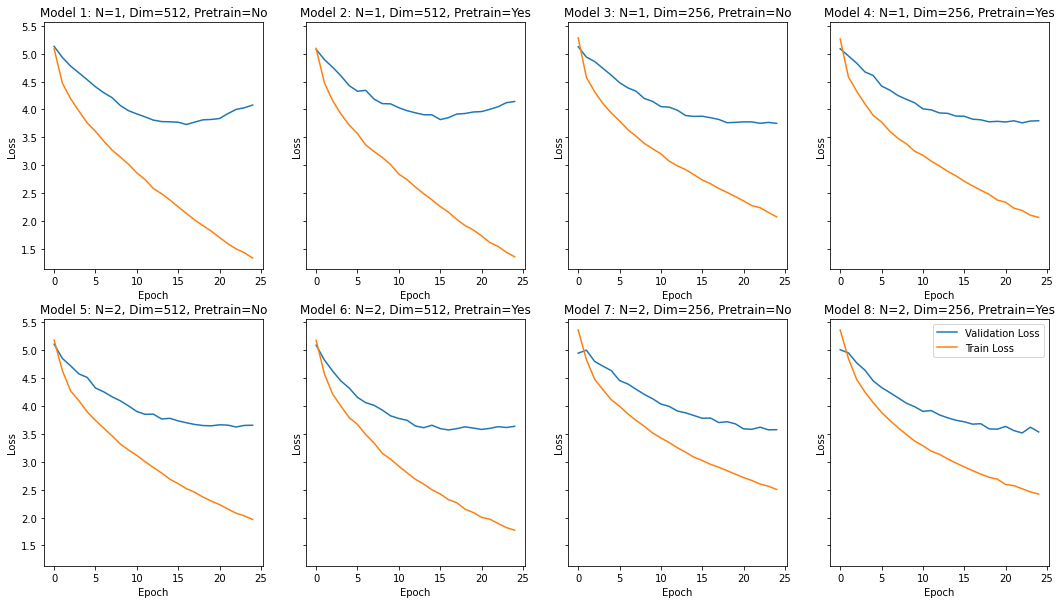

In [ ]:
#Plotting validation and train loss

fig, axs = plt.subplots(2, 4, figsize=(18,10), sharey=True)
axs[0,0].plot(range(25), df1['val_loss'], label="Validation Loss")
axs[0,0].plot(df1['train_loss'], label="Train Loss")
axs[0,0].set_title('Model 1: N=1, Dim=512, Pretrain=No')
axs[0,1].plot(range(25), df2['val_loss'], label="Validation Loss")
axs[0,1].plot(df2['train_loss'], label="Train Loss")
axs[0,1].set_title('Model 2: N=1, Dim=512, Pretrain=Yes')
axs[0,2].plot(range(25), df3['val_loss'], label="Validation Loss")
axs[0,2].plot(df3['train_loss'], label="Train Loss")
axs[0,2].set_title('Model 3: N=1, Dim=256, Pretrain=No')
axs[0,3].plot(range(25), df4['val_loss'], label="Validation Loss")
axs[0,3].plot(df4['train_loss'], label="Train Loss")
axs[0,3].set_title('Model 4: N=1, Dim=256, Pretrain=Yes')
axs[1,0].plot(range(25), df5['val_loss'], label="Validation Loss")
axs[1,0].plot(df5['train_loss'], label="Train Loss")
axs[1,0].set_title('Model 5: N=2, Dim=512, Pretrain=No')
axs[1,1].plot(range(25), df6['val_loss'], label="Validation Loss")
axs[1,1].plot(df6['train_loss'], label="Train Loss")
axs[1,1].set_title('Model 6: N=2, Dim=512, Pretrain=Yes')
axs[1,2].plot(range(25), df7['val_loss'], label="Validation Loss")
axs[1,2].plot(df7['train_loss'], label="Train Loss")
axs[1,2].set_title('Model 7: N=2, Dim=256, Pretrain=No')
axs[1,3].plot(range(25), df8['val_loss'], label="Validation Loss")
axs[1,3].plot(df8['train_loss'], label="Train Loss")
axs[1,3].set_title('Model 8: N=2, Dim=256, Pretrain=Yes')
axs[1,3].legend(loc='upper right')


for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='Loss')

plt.show()

Above are plotted the train and validation losses for each of the 8 networks.  I was surprised during preliminary experimentation that the models were overfitting after just about 15 to 20 epochs.  However, the authors of the paper only trained their models for 7.5 epochs, so apparently a short training period is not entirely unusual.  The authors worked with millions of datapoints compared to our 29,000, so perhaps this is why they did not need to train for as long.  It is interesting to note that the training loss decays very rapidly.  Also, within a few epochs, it is already far below the validation loss.  It is clear that models 1 and 2 began overfitting much earlier than the other models.  This is especially odd, considering that models 5 and 6 are much larger, yet these models did not overfit as quickly.  Usually, the more parameters a model has, the more quickly it will overfit, especially when working with small datasets.  There is no indication that using pretrained embeddings had any significant impact on training.  Models 7 and 8 appear to have achieved the lowest validation loss of all the models.

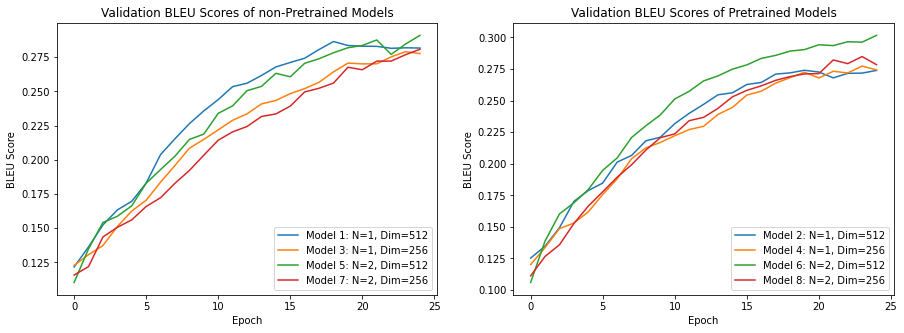

In [ ]:
#Plotting validation BLEU scores

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(range(25), df1['val_acc'], label="Model 1: N=1, Dim=512")
axs[0].plot(df3['val_acc'], label="Model 3: N=1, Dim=256")
axs[0].plot(df5['val_acc'], label="Model 5: N=2, Dim=512")
axs[0].plot(df7['val_acc'], label="Model 7: N=2, Dim=256")
axs[0].set_title('Validation BLEU Scores of non-Pretrained Models')
axs[1].plot(df2['val_acc'], label="Model 2: N=1, Dim=512")
axs[1].plot(df4['val_acc'], label="Model 4: N=1, Dim=256")
axs[1].plot(df6['val_acc'], label="Model 6: N=2, Dim=512")
axs[1].plot(df8['val_acc'], label="Model 8: N=2, Dim=256")
axs[1].set_title('Validation BLEU Scores of Pretrained Models')

for ax in axs.flat:
    ax.set(xlabel='Epoch', ylabel='BLEU Score')
    ax.legend(loc='lower right')

plt.show()

Above are the graphs of the mean BLEU scores computed on the validation data after each epoch.  By the end of training, almost all of the models converge to a BLEU score of about 0.28.  A major exception to this is model 6, which managed to achieve a BLEU score of 0.3.  It is interesting to note that this is the largest of the models.  Judging from these graphs alone, it is also the only network for which the pretrained embedding has conferred any benefit.  

In [ ]:
#Testing all models on test iterator with each smoothing method

test_results = {'Method 1': [],
                'Method 2': []}

for i in range(1,9):
    model_name = 'Model ' + str(i)
    par = params[model_name]
    model = Seq2Seq(**par).to(DEVICE)
    file_name = '/content/model'+str(i)+'.pt'
    model.load_state_dict(torch.load(file_name))
    #Test with epsilon smoothing
    _, test_results_1 = model.test(test_iterator, smooth_method='1')
    test_results['Method 1'].append(test_results_1)
    #Test with +1 smoothing
    _, test_results_2 = model.test(test_iterator, smooth_method='2')
    test_results['Method 2'].append(test_results_2)

with open('test_results.pickle', 'wb') as handle:
    pickle.dump(test_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#Calculating mean BLEU score for each model and for each smoothing method

test_results_mean = {'Method 1': [mean(lst) for lst in test_results['Method 1']],
                     'Method 2': [mean(lst) for lst in test_results['Method 2']]}

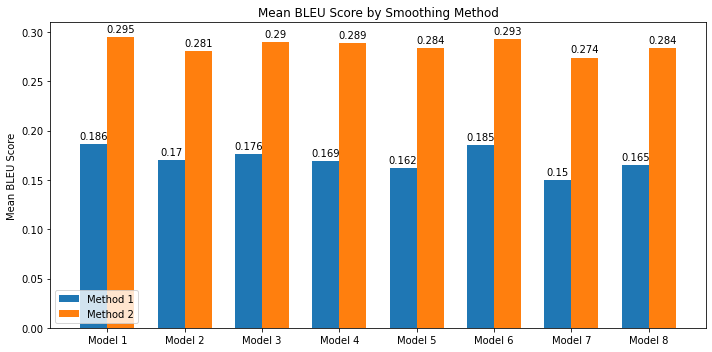

In [ ]:
#Plotting mean BLEU scores

labels = params.keys()
method_1 = [round(test_results_mean['Method 1'][i], 3) for i in range(8)]
method_2 = [round(test_results_mean['Method 2'][i], 3) for i in range(8)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, method_1, width, label='Method 1')
rects2 = ax.bar(x + width/2, method_2, width, label='Method 2')


ax.set_ylabel('Mean BLEU Score')
ax.set_title('Mean BLEU Score by Smoothing Method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower left')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

The above bar graph displays the mean BLEU score on the testing data for each network.  The details of the BLEU score were discussed in detail in Part 1 of the report.  I utilized the BLEU-4 score with equal weighting, meaning that 1- through 4-grams were considered, and all of the n-grams were treated equally.  Recall that a smoothing method is often employed when computing the scores.  The reason for this is that if there is no overlap between the target translation and the predicted translation for some n-gram, then the BLEU score automatically returns 0.  This is considered to be too harsh of an evaluation, as there may have been a great deal more overlap for the other n-grams.  Smoothing methods are therefore utilized to ameliorate this issue.  In epsilon smoothing, a very small number is added to the numerator of the computation.  In +1 smoothing, 1 is added to both the numerator and denominator.  It can be seen that there is a staggering difference of up to 12 points between the two methods.  In particular, the +1 smoothing resulted in the highest evaluation.  The large difference between the two methods may be a result of the fact that the BLEU scores are overall on the lower side.  If there was a considerable lack of overlap between n-grams across the test data, then smoothing will have a larger impact.  In these cases, +1 smoothing will have a bigger effect.  It should be noted that the authors of the paper do not indicate if they used any smoothing techniques.  However, since they used a large testing dataset and since their network achieved greater overlap between the n-grams, I do not expect the smoothing method to have a significant impact on the evaluation.  That being said, it may be prudent for researchers to note what smoothing methods have been employed.

There does not seem to be any drastic differences in the results across the 8 networks.  Models 1 and 6 achieved the highest scores, and model 3 is slightly farther behind with the third highest scores.  The only commonality between models 1 and 6 is that the hidden dimension of both was 512.  Like model 1, model 3 had 1 LSTM layer in the encoder and decoder.  Recall that the even-numbered models were given pretrained embeddings.  This may have helped models 6 and 8, but models 2 and 4 lag behind their untrained counterparts.  Therefore, it is unclear whether pretraining aided any of the networks.  Perhaps the results would have been more clear if the embedding in the decoder was also pretrained.  Overall, it is hard to conclude that any particular values for the hyperparameters results in better performance.

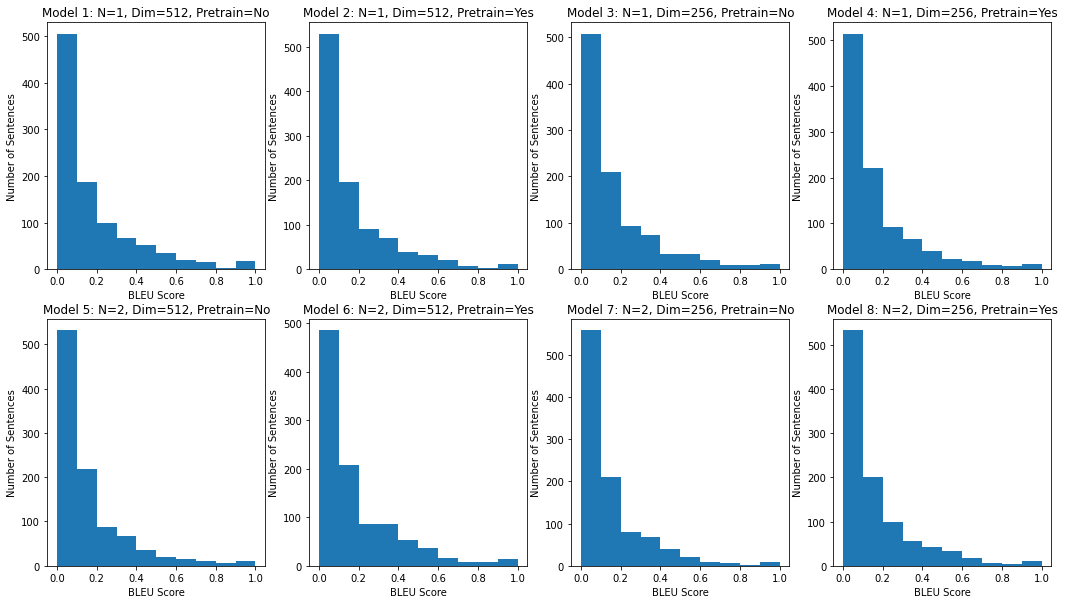

In [ ]:
#Plotting histogram of BLEU scores for each model with smoothing method 1

fig, axs = plt.subplots(2, 4, figsize=(18,10))
axs[0,0].hist(test_results['Method 1'][0])
axs[0,0].set_title('Model 1: N=1, Dim=512, Pretrain=No')
axs[0,1].hist(test_results['Method 1'][1])
axs[0,1].set_title('Model 2: N=1, Dim=512, Pretrain=Yes')
axs[0,2].hist(test_results['Method 1'][2])
axs[0,2].set_title('Model 3: N=1, Dim=256, Pretrain=No')
axs[0,3].hist(test_results['Method 1'][3])
axs[0,3].set_title('Model 4: N=1, Dim=256, Pretrain=Yes')
axs[1,0].hist(test_results['Method 1'][4])
axs[1,0].set_title('Model 5: N=2, Dim=512, Pretrain=No')
axs[1,1].hist(test_results['Method 1'][5])
axs[1,1].set_title('Model 6: N=2, Dim=512, Pretrain=Yes')
axs[1,2].hist(test_results['Method 1'][6])
axs[1,2].set_title('Model 7: N=2, Dim=256, Pretrain=No')
axs[1,3].hist(test_results['Method 1'][7])
axs[1,3].set_title('Model 8: N=2, Dim=256, Pretrain=Yes')


for ax in axs.flat:
    ax.set(xlabel='BLEU Score', ylabel='Number of Sentences')

plt.show()

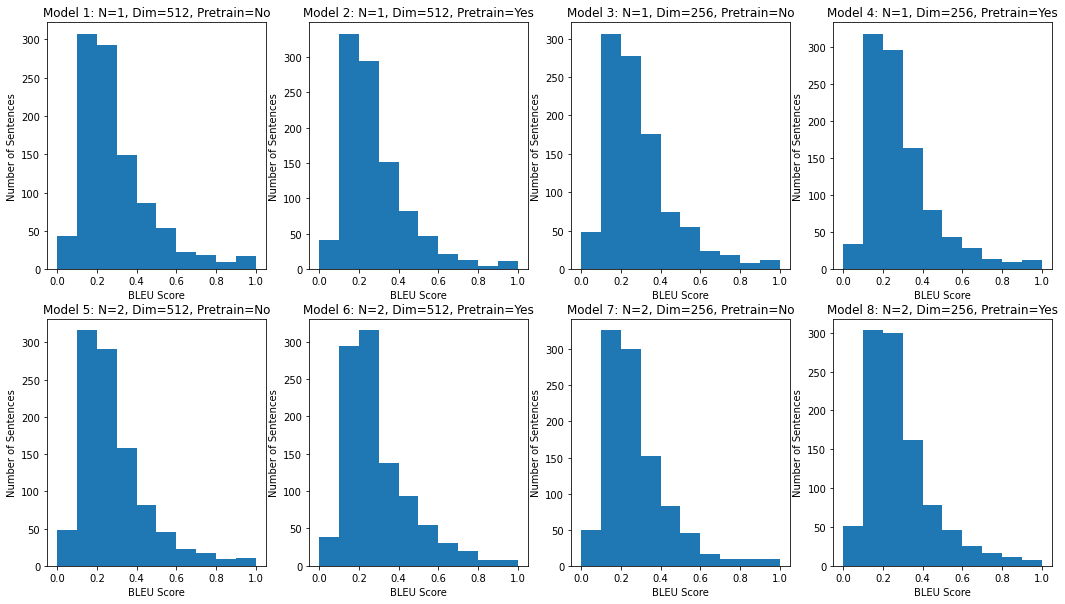

In [ ]:
#Plotting histogram of BLEU scores for each model using smoothing method 2

fig, axs = plt.subplots(2, 4, figsize=(18,10))
axs[0,0].hist(test_results['Method 2'][0])
axs[0,0].set_title('Model 1: N=1, Dim=512, Pretrain=No')
axs[0,1].hist(test_results['Method 2'][1])
axs[0,1].set_title('Model 2: N=1, Dim=512, Pretrain=Yes')
axs[0,2].hist(test_results['Method 2'][2])
axs[0,2].set_title('Model 3: N=1, Dim=256, Pretrain=No')
axs[0,3].hist(test_results['Method 2'][3])
axs[0,3].set_title('Model 4: N=1, Dim=256, Pretrain=Yes')
axs[1,0].hist(test_results['Method 2'][4])
axs[1,0].set_title('Model 5: N=2, Dim=512, Pretrain=No')
axs[1,1].hist(test_results['Method 2'][5])
axs[1,1].set_title('Model 6: N=2, Dim=512, Pretrain=Yes')
axs[1,2].hist(test_results['Method 2'][6])
axs[1,2].set_title('Model 7: N=2, Dim=256, Pretrain=No')
axs[1,3].hist(test_results['Method 2'][7])
axs[1,3].set_title('Model 8: N=2, Dim=256, Pretrain=Yes')


for ax in axs.flat:
    ax.set(xlabel='BLEU Score', ylabel='Number of Sentences')

plt.show()

The above histograms show the distribution of the per-sentence BLEU scores for each network.  The first set of histograms correspond to the epsilon smoothing, and the second set of histograms correspond to the +1 smoothing.  Within each set, the distributions are practically the same across the networks.  What is more interesting is the difference between the two sets.  For epsilon smoothing, the scores seem to roughly follow a power distribution.  For the +1 smoothing, the distrubtions are a bit closer to a normal distribution, as there seems to be clustering near the means.  Again, this probably has to do with the fact that +1 smoothing has a larger impact on low-scoring sentences.

## Some Translations

Finally, it is time to look at a few translations produced by the network.  Since model 1 performed the best, I will only be looking at some translations produced by that network.

In [ ]:
#Defining some functions to help get and print sentences

def get_sentences(idx, model):
    """
    Given a model and the index of location of tensor in train iterator
    returns the source and target sentences, the translation,
    and the bleu score of the translation.
    Sentences are returned as list of words
    """
    batch_numb = int(idx/BATCH_SIZE)
    ind = idx % BATCH_SIZE
    for i, batch in enumerate(test_iterator):
        if i == batch_numb:
            src = batch.src[:,ind]
            trg = batch.trg[:,ind]
            #Get translation
            out = model(batch.src, batch.trg)
            pred = out.argmax(2)
            pred_sent_tens = pred[:,ind]
            #Get actual sentences from tensors
            src_sent = model.retrieve_sent(src, 'source')
            trg_sent = model.retrieve_sent(trg, 'target')
            pred_sent = model.retrieve_sent(pred_sent_tens, 'target')
            #Compute scores
            bleu_score = sentence_bleu([pred_sent], trg_sent, smoothing_function=SmoothingFunction().method2)
    return src_sent, trg_sent, pred_sent, bleu_score

def print_sentences(idx, model):
    """
    Given model and index of location of tensor in test iterator,
    prints the source, target, and translated sentences along with
    the bleu score for the translation
    """
    src, trg, pred, bleu_score = get_sentences(idx, model)
    src_sent = ''
    pred_sent = ''
    trg_sent = ''
    for i in src:
        src_sent = src_sent + i + ' '
    for i in trg:
        trg_sent = trg_sent + i + ' '
    for i in pred:
        pred_sent = pred_sent + i + ' '
    print('The source sentence is:')
    print(src_sent)
    print('The target sentence is:')
    print(trg_sent)
    print('The translation is:')
    print(pred_sent)
    print('The BLEU score for this translation is:', round(bleu_score, 3))


In [ ]:
#Loading model 1 weights

model = Seq2Seq(**params1).to(DEVICE)

model.load_state_dict(torch.load('/content/model1.pt'))

<All keys matched successfully>

In [ ]:
#Finding the index of a tensor that received the maximum bleu score in the test iterator

max_idx = test_results['Method 1'][0].index(max(test_results['Method 1'][0]))

In [ ]:
print_sentences(max_idx, model)

The source sentence is:
a brown dog jumping over a hurdle 
The target sentence is:
ein brauner hund springt über eine hürde 
The translation is:
ein brauner hund springt über eine hürde 
The BLEU score for this translation is: 1.0


Above is one of the examples that the network translated perfectly.  It is of note that this is a very short and simple sentences.  In particular, it does not contain any long, complicated clauses.

In [ ]:
#Finding the indicies of the tensors in the test iterator that got average or bad
#bleu scores

avg_idx = []
bad_idx = []

for i, score in enumerate(test_results['Method 2'][0]):
    if score < .35 and score > 0.20:
        avg_idx.append(i)
    if score < 0.1:
        bad_idx.append(i)

In [ ]:
print_sentences(bad_idx[-8], model)

The source sentence is:
this player with the blue helmet was at bat and just finished swinging at the ball during a team baseball game 
The target sentence is:
dieser spieler mit dem blauen helm war in einem baseballspiel zwischen zwei teams gerade am und ist gerade mit dem schlagen fertig 
The translation is:
der basketballspieler mit der blauen trikot hält sich dem den ball den den ball an an den ball zu einem ball 
The BLEU score for this translation is: 0.07


In [ ]:
print_sentences(bad_idx[-11], model)

The source sentence is:
two race cars one red and one blue are driving side by side down a racetrack while being watched by several onlookers 
The target sentence is:
zwei rennautos eines rot und das andere blau fahren nebeneinander auf einer rennstrecke während mehrere personen zusehen 
The translation is:
ein biker und ein schwarz-weißer rennwagen auf der straße und wird von gruppe von menschen vorbei 
The BLEU score for this translation is: 0.08


In [ ]:
print_sentences(bad_idx[-12], model)

The source sentence is:
a large bull targets a man away in a rodeo with his horns while a rodeo clown runs to help 
The target sentence is:
ein großer stier versucht einen mann bei einem rodeo auf die zu nehmen während ein um zu helfen 
The translation is:
ein einzelner cowboy reitet einen pferd der ein anderer einem ein und und ihn nähern 
The BLEU score for this translation is: 0.086


The above three translations achieved BLEU scores of less than 0.1.  You do not need to know very much German to see that these are very poor translations.  It is interesting to note that the beginning of the translations start out alright but are terrible by the end of the sentence.  In the first example, the translation seems to have gotten stuck on the notion of a ball as it repeats variations on "den ball" over and over again.  In the third example, the translation fills out the second half of the setence with a bunch of indefinite articles and pronouns.  As these are long sentences, this seems to be a sign that the network is forgetting the meaning of the sentence halfway through the translation.

In [ ]:
print_sentences(avg_idx[5], model)

The source sentence is:
a dog jumps over an obstacle outside 
The target sentence is:
ein hund springt im freien über ein hindernis 
The translation is:
ein hund springt über einem 
The BLEU score for this translation is: 0.316


In [ ]:
print_sentences(avg_idx[6], model)

The source sentence is:
a view of a crowded city street 
The target sentence is:
eine ansicht einer belebten straße in der stadt 
The translation is:
ein menschenmenge einer belebten straße innenstadt 
The BLEU score for this translation is: 0.298


In [ ]:
print_sentences(avg_idx[7], model)

The source sentence is:
3 men cooking in a small kitchen 
The target sentence is:
3 männer kochen in einer kleinen küche 
The translation is:
drei männer in an einer bar kunstgalerie 
The BLEU score for this translation is: 0.221


The final three examples all achieved about average BLEU scores between 0.2 and 0.35.  These are very short sentences like the first and contain simple prepositional phrases. In the first case, the translation gets the subject and verb correct, but does not translate the preposition very well.  The third gets the subject right but does not seem to grasp the verb.  In the second example, the translation mistakes the adjective 'crowded' for the subject of the sentence (as 'menshenmenge' means 'crowd').  

## Discussion and Conclusion

In this report, I have implemented a simple seq2seq model on the Multi30k dataset.  I looked at how the network performed for two different LSTM depths and two different values for the hidden dimension.  In addition, I compared using a pretrained embedding versus using an untrained embedding.  Overall, the results for all of the models are about the same.  Therefore, I am unable to conclude that any particular set of hyperparameters is superior to another or that using a pretrained embedding is necessary.  However, I was limited by the smaller size of the dataset.  A larger dataset may have revealed differences between the networks.  Also, the authors of the paper were able to train a network with LSTMs that had 4 layers.  This undoubtably gives their network more capacity, but considering the small dataset that we are working with, I thought it was prudent to stick to smaller networks.  The difference between the epsilon smoothing and +1 smoothing in the BLEU evaluations was the most surprising result.  As I discussed, this difference may have been due to the overall lower per-sentence BLEU scores.  However, the results demonstrate that it is important to verify what type of smoothing is used in the evaluation of a machine translation network.